# Project 1: Handwriting Analysis, Recognition, and Synthesis Platform

## Overview:

Develop an end-to-end system that not only recognizes handwritten text but also generates synthetic handwriting samples. This project lets you explore classical predictive methods, modern neural network architectures, and generative modeling.

## Key Components:

1. Data Preprocessing & Feature Extraction

   - Introduction & Linear Prediction:  
   Start by exploring handwriting datasets (e.g., MNIST, IAM Handwriting) and perform basic feature extraction. Use linear prediction models to establish baseline performance.

2. Classification and Regression

   - Maximum Likelihood & Logistic Regression:  
   Implement logistic regression to classify individual characters or digits, using maximum likelihood estimation for parameter fitting.

3. Model Improvement Techniques

   - Regularizers, Basis Functions, and Cross-Validation:  
   Apply L1/L2 regularization and basis function transformations to your baseline models, using cross-validation to fine-tune hyperparameters.

4. Neural Network Design and Training

   - Backpropagation, Layer-wise Design, and Optimization:
   Build a multi-layer neural network using Torch. Implement backpropagation manually on a smaller subset for understanding, then switch to Torch’s automatic differentiation. Experiment with various optimization algorithms (SGD, Adam).

5. Convolutional Neural Networks (CNNs) for Recognition

   - Image Classification:
   Design a CNN to improve recognition accuracy on the handwriting dataset. Explore different architectures, activation functions, and pooling methods.

6. Siamese Networks for Writer Verification

   - Max-margin Learning:
   Implement a Siamese network that learns to distinguish between writing styles (or even verify a writer’s identity) using contrastive loss.

7. Sequence Modeling and Handwriting Synthesis

   - Recurrent Neural Networks and LSTMs:
   Develop an RNN (or LSTM variant) to model the sequential nature of handwriting strokes. Train it on sequences extracted from handwriting data to generate new text sequences.

8. Advanced Handwriting Generation

   - Handwriting with RNNs:
   Take inspiration from Alex Graves’ work to refine your handwriting synthesis. Fine-tune your RNN so that generated samples mimic real handwriting nuances.

9. Generative Modeling for Data Augmentation

   - Variational Autoencoders (VAEs):
   Integrate a VAE to generate additional synthetic handwriting images. Experiment with latent space dimensions to observe how variations affect output quality.


In [13]:
import torch
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import copy

1. Data Preprocessing & Feature Extraction

   - Introduction & Linear Prediction:  
   Start by exploring handwriting datasets (e.g., MNIST, IAM Handwriting) and perform basic feature extraction. Use linear prediction models to establish baseline performance.

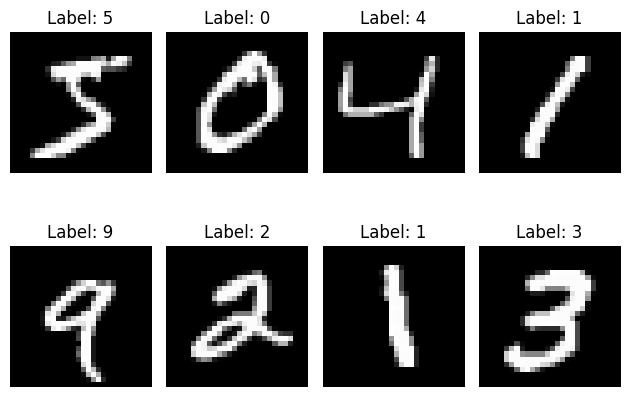

In [14]:
# Load the MNIST dataset
train_imagefile = 'mnist_dataset/train-images.idx3-ubyte'
train_imagearray = idx2numpy.convert_from_file(train_imagefile)

train_labelfile = 'mnist_dataset/train-labels.idx1-ubyte'
train_labelarray = idx2numpy.convert_from_file(train_labelfile)

test_imagefile = 'mnist_dataset/t10k-images.idx3-ubyte'
test_imagearray = idx2numpy.convert_from_file(test_imagefile)

test_labelfile = 'mnist_dataset/t10k-labels.idx1-ubyte'
test_labelarray = idx2numpy.convert_from_file(test_labelfile)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        if len(images) != len(labels):
            raise ValueError('Number of images and labels must be the same')
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(copy.deepcopy(images)).to(device)
        if isinstance(labels, np.ndarray):
            labels = torch.from_numpy(copy.deepcopy(labels)).to(device)
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].to(dtype=torch.float32)
        label = self.labels[idx].to(dtype=torch.int64)
        return image, label

train_dataset = MNISTDataset(train_imagearray, train_labelarray)
test_dataset = MNISTDataset(test_imagearray, test_labelarray)

# Create a DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot the first 8 training images
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image, label = train_dataset[i]
    ax.imshow(image.cpu(), cmap='gray')
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

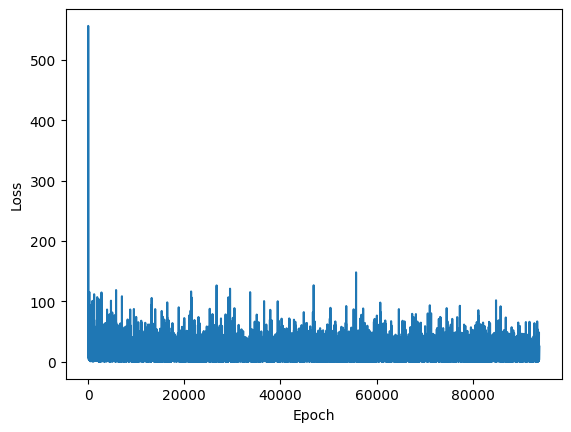

Accuracy: 86.71%


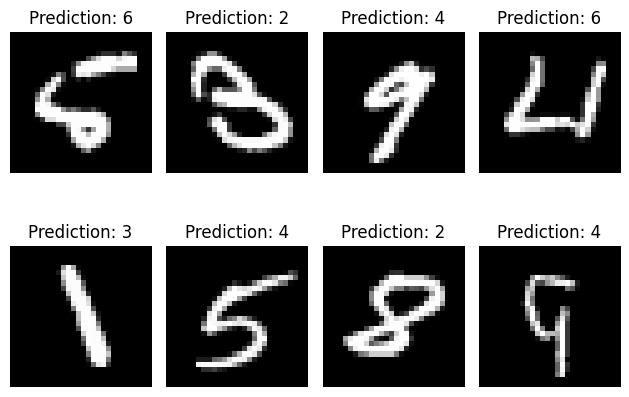

In [15]:
# Linear prediction model
model = torch.nn.Linear(28*28, 10, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
losses = []
for epoch in range(100):
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model and plot a few images failed to predict
correct = 0
total = 0
failed_images = []
failed_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(failed_images) < 8:
            failed_images.extend(images[predicted != labels])
            failed_predictions.extend(predicted[predicted != labels])

print(f'Accuracy: {correct/total*100:.2f}%')

failed_images = torch.stack(failed_images).view(-1, 28, 28).cpu()
failed_predictions = torch.stack(failed_predictions).cpu()
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image = failed_images[i]
    label = failed_predictions[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


2. Classification and Regression

   - Maximum Likelihood & Logistic Regression:  
   Implement logistic regression to classify individual characters or digits, using maximum likelihood estimation for parameter fitting.

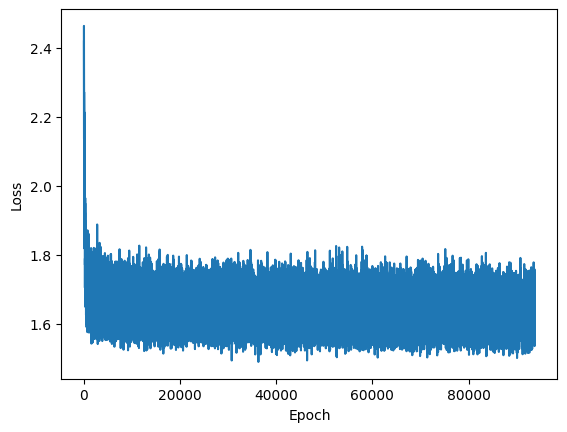

Accuracy: 80.44%


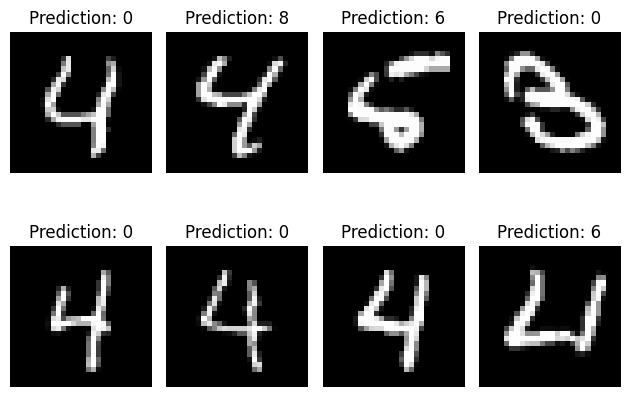

In [16]:
# Logistic regression model
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(28*28, 10).to(device)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x)).to(device)

# Create a model, loss function and optimizer
model = LogisticRegression()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
losses = []
for epoch in range(100):
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model and plot a few images failed to predict
correct = 0
total = 0
failed_images = []
failed_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(failed_images) < 8:
            failed_images.extend(images[predicted != labels])
            failed_predictions.extend(predicted[predicted != labels])

print(f'Accuracy: {correct/total*100:.2f}%')

failed_images = torch.stack(failed_images).view(-1, 28, 28).cpu()
failed_predictions = torch.stack(failed_predictions).cpu()
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image = failed_images[i]
    label = failed_predictions[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

3. Model Improvement Techniques

   - Regularizers, Basis Functions, and Cross-Validation:  
   Apply L1/L2 regularization and basis function transformations to your baseline models, using cross-validation to fine-tune hyperparameters.

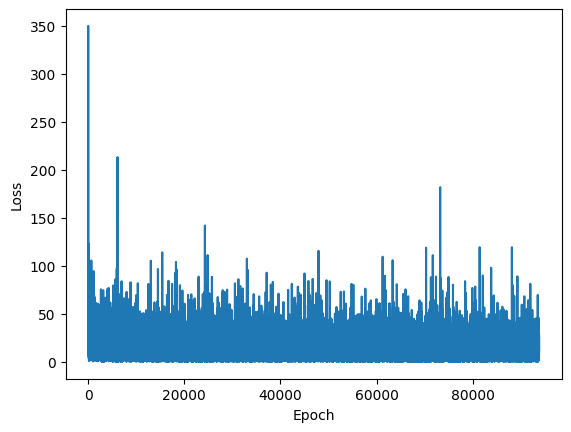

Accuracy: 88.62%


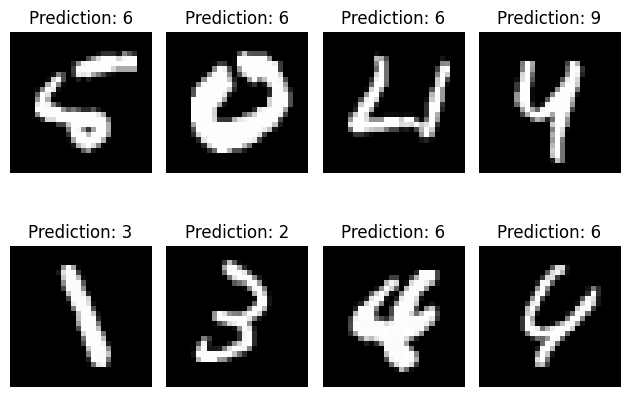

In [17]:
# Linear prediction model with regularization
model = torch.nn.Linear(28*28, 10, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
losses = []
for epoch in range(100):
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model and plot a few images failed to predict
correct = 0
total = 0
failed_images = []
failed_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(failed_images) < 8:
            failed_images.extend(images[predicted != labels])
            failed_predictions.extend(predicted[predicted != labels])

print(f'Accuracy: {correct/total*100:.2f}%')

failed_images = torch.stack(failed_images).view(-1, 28, 28).cpu()
failed_predictions = torch.stack(failed_predictions).cpu()
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image = failed_images[i]
    label = failed_predictions[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


4. Neural Network Design and Training

   - Backpropagation, Layer-wise Design, and Optimization:
   Build a multi-layer neural network using Torch. Implement backpropagation manually on a smaller subset for understanding, then switch to Torch’s automatic differentiation. Experiment with various optimization algorithms (SGD, Adam).

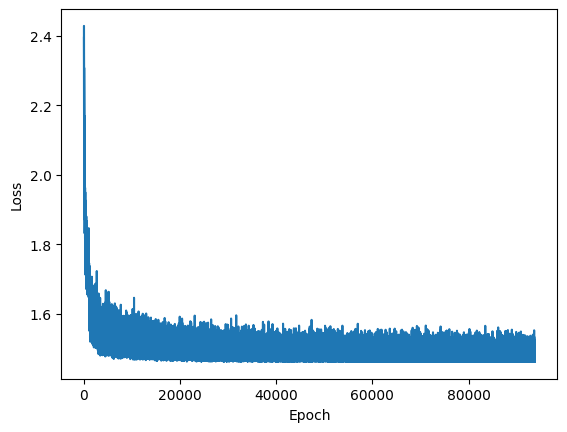

Accuracy: 96.73%


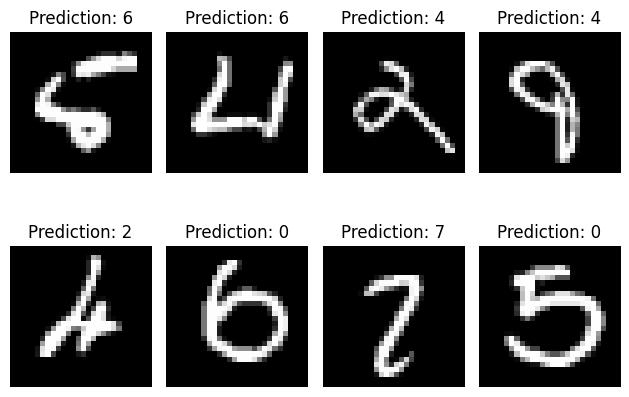

In [20]:
# Custom neural network model with linear layers, ReLU activation and logisitic regression output
class CustomNN(torch.nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.linear1 = torch.nn.Linear(28*28, 128).to(device)
        self.relu = torch.nn.ReLU().to(device)
        self.linear2 = torch.nn.Linear(128, 10).to(device)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return torch.sigmoid(x).to(device)

# Create a model, loss function and optimizer
model = CustomNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
losses = []
for epoch in range(100):
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model and plot a few images failed to predict
correct = 0
total = 0
failed_images = []
failed_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device=device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(failed_images) < 8:
            failed_images.extend(images[predicted != labels])
            failed_predictions.extend(predicted[predicted != labels])

print(f'Accuracy: {correct/total*100:.2f}%')

failed_images = torch.stack(failed_images).view(-1, 28, 28).cpu()
failed_predictions = torch.stack(failed_predictions).cpu()
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image = failed_images[i]
    label = failed_predictions[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


5. Convolutional Neural Networks (CNNs) for Recognition

   - Image Classification:
   Design a CNN to improve recognition accuracy on the handwriting dataset. Explore different architectures, activation functions, and pooling methods.

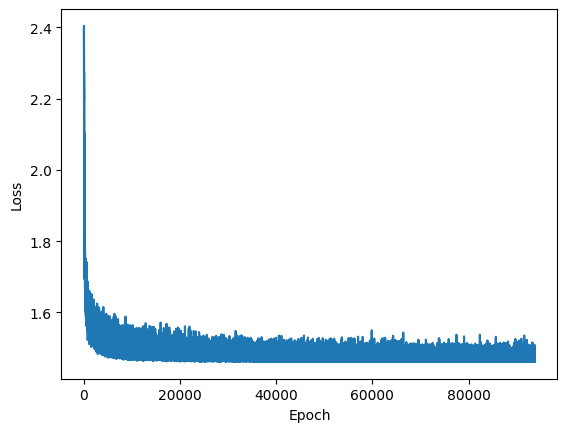

Accuracy: 98.43%


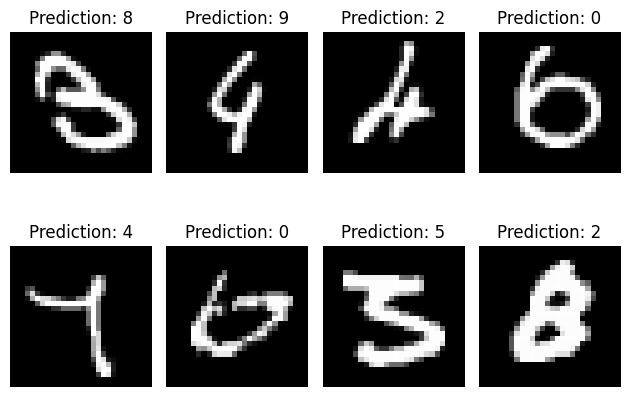

In [29]:
# CNN model
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, 3, 1, 1).to(device)
        self.conv2 = torch.nn.Conv2d(8, 16, 3, 1, 1).to(device)
        self.pool = torch.nn.MaxPool2d(2, 2).to(device)
        self.linear1 = torch.nn.Linear(16*7*7, 128).to(device)
        self.relu = torch.nn.ReLU().to(device)
        self.linear2 = torch.nn.Linear(128, 10).to(device)
    
    def forward(self, x):
        x = self.conv1(x).to(device)
        x = self.pool(x).to(device)
        x = self.conv2(x).to(device)
        x = self.pool(x).to(device)
        x = x.view(-1, 16*7*7).to(device)
        x = self.linear1(x).to(device)
        x = self.relu(x).to(device)
        x = self.linear2(x).to(device)
        return torch.sigmoid(x).to(device)

# Create a model, loss function and optimizer
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
losses = []
for epoch in range(100):
    for images, labels in train_loader:
        images = images.view(-1, 1, 28, 28).to(device=device)
        pred = model(images)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model and plot a few images failed to predict
correct = 0
total = 0
failed_images = []
failed_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28).to(device=device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(failed_images) < 8:
            failed_images.extend(images[predicted != labels])
            failed_predictions.extend(predicted[predicted != labels])

print(f'Accuracy: {correct/total*100:.2f}%')

failed_images = torch.stack(failed_images).view(-1, 28, 28).cpu()
failed_predictions = torch.stack(failed_predictions).cpu()
fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    image = failed_images[i]
    label = failed_predictions[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


6. Siamese Networks for Writer Verification

   - Max-margin Learning:
   Implement a Siamese network that learns to distinguish between writing styles (or even verify a writer’s identity) using contrastive loss.